In [374]:
import bitermplus as btm
import numpy as np
import pandas as pd
import statistics
import scipy.stats
import optuna
import plotly.express as px
import tmplot as tmp

language = "Go"

def contexts_to_text(contexts):
    return " ".join([" ".join(context) + "." for context in eval(contexts)])

repos = pd.read_csv(f"processed_readmes_{language.lower()}.csv", sep=";", quotechar="'")

repos["TEXT_PROCESSED"] = repos["CONTEXTS"].transform(contexts_to_text)

texts = repos["TEXT_PROCESSED"]

language_removed_words = {"Go": ["go", "golang"], "Java": ["java"], "Python": ["python"], "Ruby": ["ruby"]}
common_removed_words = ["library", "package"]

X, vocabulary, vocab_dict = btm.get_words_freqs(texts, binary=False, stop_words=language_removed_words[language]+common_removed_words, min_df=0.05) # It can take whatever parameter CounterVectorizer can take: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
docs_vec = btm.get_vectorized_docs(texts, vocabulary)
biterms = btm.get_biterms(docs_vec)

In [375]:
"""
In general, higher alpha values mean documents contain more similar topic contents. 
The same is true for beta, but with topics and words: generally a high beta will result in topics with more similar word contents. 
Also, an asymmetric alpha is helpful, where as an asymmetric beta is largely not.
"""

model = btm.BTM(X, vocabulary, seed=42, T=10, M=5, win=100, alpha=1/10, beta=0.01, has_background=False)
model.fit(biterms, iterations=1000)

print(model.perplexity_)
print(min(model.coherence_))
print(max(model.coherence_))
print(statistics.mean(model.coherence_))
print(statistics.median(model.coherence_))
print(statistics.stdev(model.coherence_)/statistics.mean(model.coherence_))

scipy.stats.describe(model.coherence_)

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 16388.03it/s]

inf
-23.442266384713342
-17.794317988035655
-21.90871244659127
-23.328951449128606
-0.0996166106844085


DescribeResult(nobs=10, minmax=(-23.442266384713342, -17.794317988035655), mean=-21.90871244659127, variance=4.763182626968952, skewness=1.115171019045193, kurtosis=-0.3764812634296115)

In [376]:
median_coherence = statistics.median(model.coherence_)
mean_coherence = statistics.mean(model.coherence_)


for i, coherence in enumerate(model.coherence_):
    if coherence >= mean_coherence:
        print(i, coherence)

0 -21.63629973025786
1 -21.269077559261707
3 -18.30040555800111
9 -17.794317988035655


In [5]:
def objective(trial):
    
    # alpha = trial.suggest_float("alpha", 0.02, 0.2, log=True)
    # beta = trial.suggest_float("beta", 0.005, 0.02, log=True)
    n_topic = trial.suggest_int("n_topic", 5, 50, log=False)
    # has_background = trial.suggest_categorical("has_background", [True, False])
    
    model = btm.BTM(X, vocabulary, seed=42, T=n_topic, M=20, alpha=1/n_topic, beta=0.01, has_background=False)
    model.fit(biterms, iterations=1000, verbose=False)

    return model.perplexity_

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_jobs=5, show_progress_bar=True)

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [359]:
numbers_of_topic = list(range(5, 101, 5))
perplexity_results = []
min_coherences = []
max_coherences = []
median_coherences = []

for n_topic in numbers_of_topic:
    print(n_topic)
    model = btm.BTM(X, vocabulary, seed=42, T=n_topic, M=3, alpha=1/2*n_topic, beta=0.01, has_background=False)
    model.fit(biterms, iterations=600, verbose=True)
    print(model.perplexity_)
    perplexity_results.append(model.perplexity_)
    min_coherences.append(min(model.coherence_))
    max_coherences.append(max(model.coherence_))
    median_coherences.append(statistics.median(model.coherence_))

5


100%|██████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 5263.34it/s]


247.76608685082167
10


100%|██████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 4055.23it/s]


3586897230.075497
15


100%|██████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 2672.91it/s]


7.770381306620508e+104
20


100%|██████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 2174.61it/s]


0.009932760062171073
25


100%|██████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 1960.40it/s]


1.217546793846762e+224
30


100%|██████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 1479.28it/s]


6.060147454733512e+56
35


100%|██████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 1304.28it/s]


3.956821105528027e-38
40


100%|██████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 1265.82it/s]


7.397057842298237e+34
45


100%|██████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 1132.21it/s]


1.5857415872896495e+282
50


100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 990.00it/s]


0.05143400688578911
55


100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 879.66it/s]


569.055449061299
60


100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 843.79it/s]


3.3255689474004684e+159
65


100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 786.82it/s]


4.605419041812008e+31
70


100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 749.94it/s]


2.7762620358208167e-14
75


100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 683.34it/s]


3.2645380051353244e+188
80


100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 649.12it/s]


4.5282631654301944e+110
85


100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 604.23it/s]


2.3806325316923248e+17
90


100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 564.75it/s]


1.0952359387217135e-32
95


100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 550.71it/s]


6.028945857811782e+69
100


100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 516.58it/s]

3.878399574311808e-11


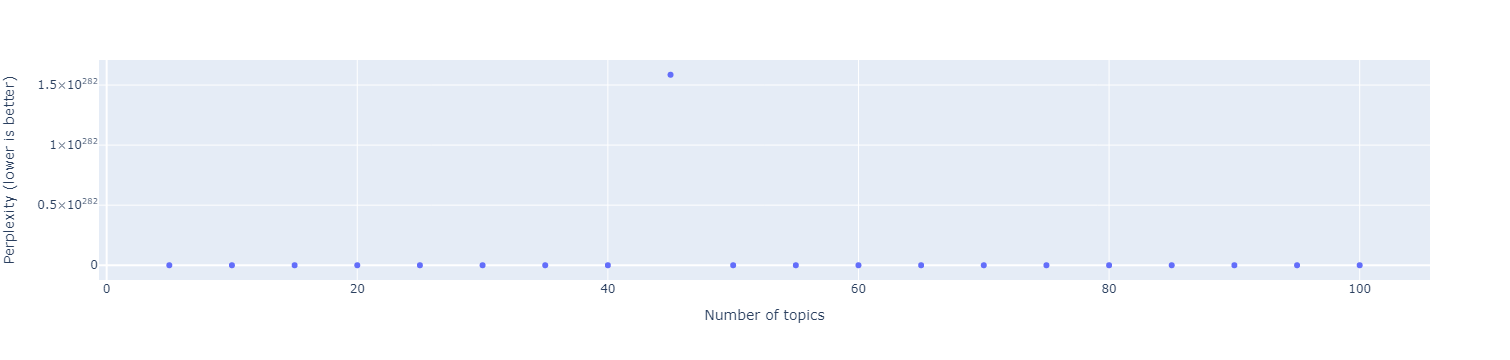

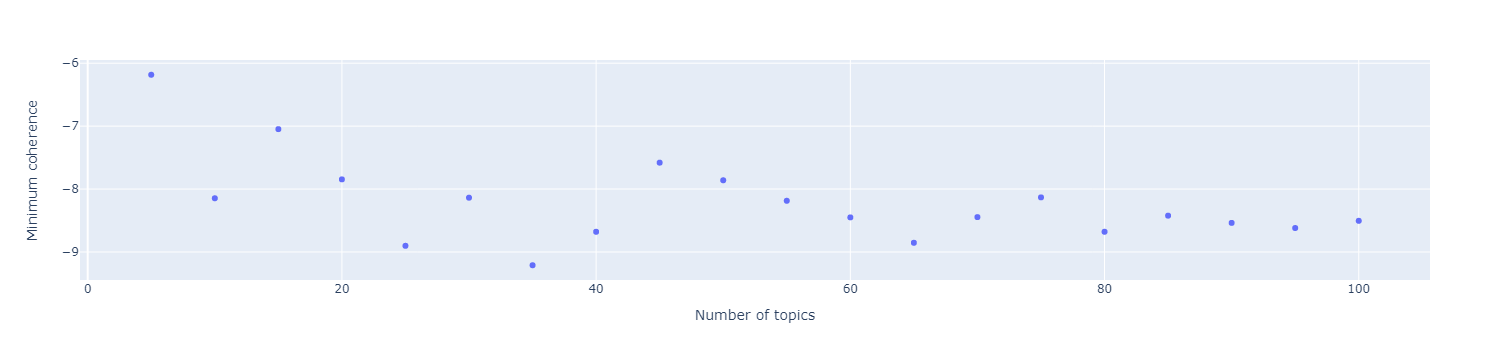

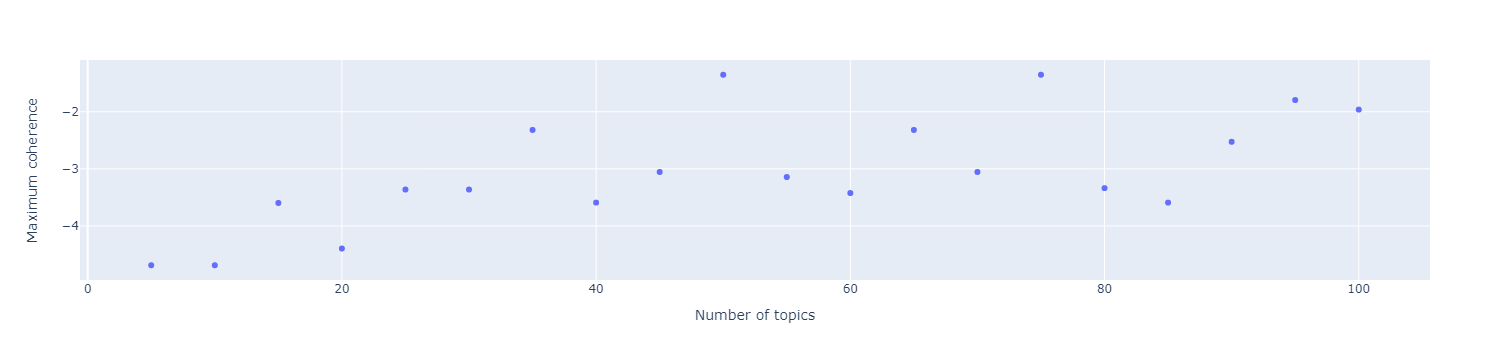

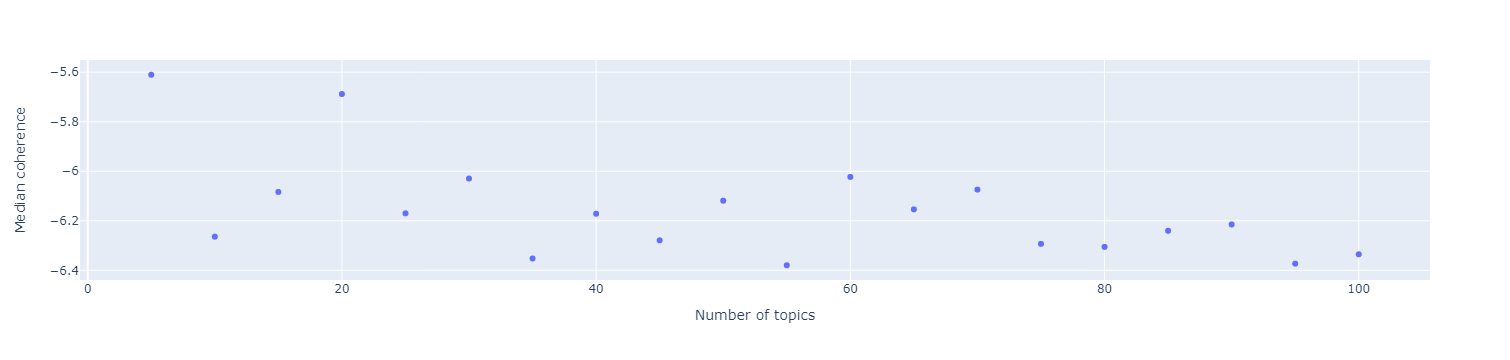

In [360]:
fig = px.scatter(x=numbers_of_topic, y=perplexity_results, log_y=False, labels={"y": "Perplexity (lower is better)", "x": "Number of topics"})
fig.show()

fig = px.scatter(x=numbers_of_topic, y=min_coherences, log_y=False, labels={"y": "Minimum coherence", "x": "Number of topics"})
fig.show()

fig = px.scatter(x=numbers_of_topic, y=max_coherences, log_y=False, labels={"y": "Maximum coherence", "x": "Number of topics"})
fig.show()

fig = px.scatter(x=numbers_of_topic, y=median_coherences, log_y=False, labels={"y": "Median coherence", "x": "Number of topics"})
fig.show()

In [226]:
p_zd = model.transform(docs_vec)

p_zd.shape
p_zd

100%|████████████████████████████████████████████████████████████████████████████| 1362/1362 [00:00<00:00, 2672.77it/s]


array([[2.38784170e-07, 2.38784170e-07, 3.71944398e-02, ...,
        1.18561139e-02, 2.01748315e-03, 2.42880445e-03],
       [6.85973892e-08, 6.85973892e-08, 9.74885355e-03, ...,
        2.23053558e-03, 6.17937485e-04, 8.36502322e-06],
       [1.03561254e-07, 1.03561254e-07, 2.98071571e-03, ...,
        5.38668472e-03, 2.24798902e-03, 7.43036602e-05],
       ...,
       [3.44563151e-07, 3.44563151e-07, 3.14941610e-03, ...,
        6.22433016e-03, 1.85367913e-03, 8.22057181e-05],
       [3.29890278e-07, 3.29890278e-07, 4.19156201e-03, ...,
        2.00034448e-05, 3.14616047e-04, 6.84716243e-06],
       [2.00267003e-07, 2.00267003e-07, 2.03645014e-02, ...,
        2.67466102e-02, 1.10531317e-05, 8.38063791e-04]])

In [ ]:
# model.biterms_

In [ ]:
# model.matrix_words_topics_.shape

In [377]:
mean_coherence = statistics.mean(model.coherence_)    

stable_topics = []
for topic_id, topic_coherence in enumerate(model.coherence_):
    if topic_coherence >= mean_coherence:
    # if topic_coherence > 0:
        stable_topics.append(topic_id)
        
print("Stable topics:", stable_topics)

def classify_doc(likelihoods, stable_topics=None):
    if stable_topics is None:
        stable_topics = list(range(0, likelihoods.shape[0]))
    filtered_max = max([likelihood for topic_id, likelihood in enumerate(likelihoods) if topic_id in stable_topics])
    return np.where(likelihoods == filtered_max)[0][0]

def get_top_n_topics(topic_doc_counts, n):
    top_n = sorted(topic_doc_counts.items(), key=lambda x: x[1], reverse=True)[:n]
    return [topic[0] for topic in top_n]

docs_topic_likelihoods = model.transform(docs_vec)

repos["TOPIC"] = [classify_doc(likelihoods, stable_topics=None) for likelihoods in docs_topic_likelihoods]

topic_doc_counts = repos["TOPIC"].value_counts().to_dict()

# for topic, count in topic_doc_counts.items():
#     print(topic, count)

px.histogram(repos["TOPIC"].value_counts())

top_topics = get_top_n_topics(topic_doc_counts, 10)

print(top_topics)

# repos[repos.TOPIC == "5"]

display(btm.get_top_topic_words(model, words_num=10, topics_idx=top_topics))

pd.set_option('display.width', 2000)

print("Document counts by topic and some examples:")
for topic in top_topics:
    print(f"Topic {topic}: {topic_doc_counts[topic]} repos")
    display(repos[repos.TOPIC == topic][0:10])

Stable topics: [0, 1, 3, 9]


100%|████████████████████████████████████████████████████████████████████████████| 776/776 [00:00<00:00, 153144.49it/s]

[0, 9, 6, 3, 1]


,topic0,topic9,topic6,topic3,topic1
0,use,file,kubernetes,service,data
1,provide,tool,tool,application,write
2,service,provide,write,write,use
3,kubernetes,write,use,use,tool
4,client,use,support,tool,support
5,build,support,simple,support,simple
6,application,simple,service,simple,service
7,implementation,service,provide,provide,provide
8,write,kubernetes,implementation,kubernetes,kubernetes
9,tool,implementation,file,implementation,implementation


Document counts by topic and some examples:
Topic 0: 746 repos


,OWNER,NAME,CONTEXTS,TEXT_PROCESSED,TOPIC
0,0x19,goesl,"[[""goesl"", ""small"", ""wrapper"", ""around"", ""free...",goesl small wrapper around freeswitch event so...,0
1,110y,handy-spanner,"[[""note"", ""want"", ""use"", ""feature"", ""e"", ""g"", ...",note want use feature e g array literal dml re...,0
2,13meimei,nutsdb,"[[""nutsdb"", ""simple"", ""fast"", ""embeddable"", ""p...",nutsdb simple fast embeddable persistent key v...,0
3,15me,uint256,"[[""library"", ""specialize"", ""replace"", ""big.int...",library specialize replace big.int library mat...,0
4,1dustindavis,gorilla,"[[""munki-like"", ""application"", ""management"", ""...",munki-like application management window.,0
5,a630140621,ufile-gosdk,"[[""bucketfilefilebucketkey"", ""bucket"", ""key"", ...",bucketfilefilebucketkey bucket key bucket buck...,0
6,a8m,documentdb,"[[""authenticate"", ""cosmos"", ""db"", ""use"", ""azur...",authenticate cosmos db use azure ad service pr...,0
7,a8m,golang-cheat-sheet,"[[""example"", ""code"", ""take"", ""tour"", ""go"", ""ex...",example code take tour go excellent introducti...,0
8,a8m,tree,"[[""take"", ""look"", ""cmd"", ""tree"", ""s3tree"", ""se...",take look cmd tree s3tree see example.,0
9,abhi,libcni,"[[""generic"", ""cni"", ""library"", ""provide"", ""api...",generic cni library provide apis cni plugin in...,0


Topic 9: 22 repos


,OWNER,NAME,CONTEXTS,TEXT_PROCESSED,TOPIC
94,C2FO,vfs,"[[""package"", ""vfs"", ""provide"", ""pluggable"", ""e...",package vfs provide pluggable extensible opini...,9
117,claudiodangelis,qrcp,"[[""transfer"", ""file"", ""wi-fi"", ""computer"", ""mo...",transfer file wi-fi computer mobile device sca...,9
138,coreos,container-linux-config-transpiler,"[[""config"", ""transpiler"", ""ct"", ""short"", ""util...",config transpiler ct short utility responsible...,9
177,deluan,fscache,"[[""stream"", ""file"", ""cache"", ""#golang""]]",stream file cache #golang.,9
216,env0,terratag,"[[""terratag"", ""cli"", ""tool"", ""allow"", ""tag"", ""...",terratag cli tool allow tag label apply across...,9
219,ericonr,sbctl,"[[""sbctl"", ""intend"", ""user-friendly"", ""secure""...",sbctl intend user-friendly secure boot key man...,9
304,gokrazy,tools,"[[""create"", ""individual"", ""file"", ""system"", ""i...",create individual file system image allow conv...,9
305,golang,review,"[[""git-codereview"", ""tool"", ""command-line"", ""t...",git-codereview tool command-line tool work ger...,9
320,google,licenseclassifier,"[[""license"", ""classifier"", ""library"", ""set"", ""...",license classifier library set tool analyze te...,9
339,gruntwork-io,fetch,"[[""fetch"", ""make"", ""easy"", ""download"", ""file"",...",fetch make easy download file folder release a...,9


Topic 6: 5 repos


,OWNER,NAME,CONTEXTS,TEXT_PROCESSED,TOPIC
25,alexellis,arkade,"[[""arkade"", ""developer"", ""install"", ""late"", ""v...",arkade developer install late version favourit...,6
106,ccojocar,sso-operator,"[[""single"", ""sign-on"", ""kubernetes"", ""operator...",single sign-on kubernetes operator dex provisi...,6
152,cruise-automation,k-rail,"[[""k-rail"", ""workload"", ""policy"", ""enforcement...",k-rail workload policy enforcement tool kubern...,6
548,nuvo,orca,"[[""orca"", ""advanced"", ""ci"", ""cd"", ""tool"", ""foc...",orca advanced ci cd tool focus world around ku...,6
706,tuenti,secrets-manager,"[[""tool"", ""keep"", ""kubernetes"", ""secret"", ""syn...",tool keep kubernetes secret sync vault.,6


Topic 3: 2 repos


,OWNER,NAME,CONTEXTS,TEXT_PROCESSED,TOPIC
217,envoyproxy,ratelimit,"[[""rate"", ""limit"", ""service"", ""go"", ""grpc"", ""s...",rate limit service go grpc service design enab...,3
337,grpc-ecosystem,grpc-health-probe,"[[""grpc_health_probe"", ""utility"", ""allow"", ""qu...",grpc_health_probe utility allow query health g...,3


Topic 1: 1 repos


,OWNER,NAME,CONTEXTS,TEXT_PROCESSED,TOPIC
741,vmware,vmware-go-kcl,"[[""amazon"", ""kinesis"", ""enable"", ""real-time"", ...",amazon kinesis enable real-time processing str...,1


In [ ]:
# phi = tmp.get_phi(model)

# terms_probs = tmp.calc_terms_probs_ratio(phi, topic=0, lambda_=0.6)
# tmp.plot_terms(terms_probs)

In [378]:
tmp.report(model=model, docs=texts)